In [ ]:
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [ ]:
class SliceSampler:
    """
    Slice Sampler for 1D distributions using stepping-out and shrinkage procedures.

    Reference: Neal, R. M. (2003). Slice sampling. Annals of statistics, 705-741.
    """

    def __init__(
        self,
        log_pdf: Callable[[float], float],
        w: float = 1.0,
        m: int = 100,
        verbose: bool = False,
    ):
        """
        Initialize the Slice Sampler.

        Parameters:
        -----------
        log_pdf : Callable
            Log probability density function (or unnormalized log density)
        w : float
            Initial width of the slice interval (step size for stepping out)
        m : int
            Maximum number of steps for stepping out procedure
        verbose : bool
            If True, print debugging information
        """
        self.log_pdf = log_pdf
        self.w = w
        self.m = m
        self.verbose = verbose
        self.n_evals = 0  # Track number of log_pdf evaluations

    def _eval_log_pdf(self, x: float) -> float:
        """Wrapper to count evaluations of log_pdf."""
        self.n_evals += 1
        return self.log_pdf(x)

    def stepping_out(self, x0: float, log_y: float) -> Tuple[float, float]:
        """
        Find an interval around x0 using the stepping-out procedure.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice

        Returns:
        --------
        (L, R) : tuple
            Left and right boundaries of the interval
        """
        # Random initial interval around x0
        u = np.random.uniform()
        L = x0 - self.w * u
        R = L + self.w

        # Randomly allocate the maximum number of steps to left and right
        j = np.floor(self.m * np.random.uniform())
        k = (self.m - 1) - j

        # Step out to the left
        while j > 0 and self._eval_log_pdf(L) > log_y:
            L = L - self.w
            j = j - 1

        # Step out to the right
        while k > 0 and self._eval_log_pdf(R) > log_y:
            R = R + self.w
            k = k - 1

        if self.verbose:
            print(f"Stepping out: interval = [{L:.4f}, {R:.4f}]")

        return L, R

    def shrinkage(self, x0: float, log_y: float, L: float, R: float) -> float:
        """
        Sample from the interval [L, R] using the shrinkage procedure.

        Parameters:
        -----------
        x0 : float
            Current position
        log_y : float
            Log height of the horizontal slice
        L : float
            Left boundary of interval
        R : float
            Right boundary of interval

        Returns:
        --------
        x1 : float
            New sample from the slice
        """

        while True:
            # Sample uniformly from [L, R]
            x1 = np.random.uniform(L, R)

            # Accept if x1 is on the slice
            if self._eval_log_pdf(x1) > log_y:
                if self.verbose:
                    print(f"Shrinkage: accepted x1 = {x1:.4f}")
                return x1

            # Shrink the interval
            if x1 < x0:
                L = x1
            else:
                R = x1

            if self.verbose:
                print(f"Shrinkage: interval shrunk to [{L:.4f}, {R:.4f}]")

            # Safety check to avoid infinite loop
            if R - L < 1e-10:
                if self.verbose:
                    print("Warning: Interval too small, returning midpoint")
                return (L + R) / 2

    def sample_one(self, x0: float) -> float:
        """
        Generate one sample using slice sampling.

        Parameters:
        -----------
        x0 : float
            Current position

        Returns:
        --------
        x1 : float
            New sample
        """
        # Step 1: Sample auxiliary variable (height of the slice)
        log_y = self._eval_log_pdf(x0) - np.random.exponential(1)

        # Step 2: Find interval using stepping-out
        L, R = self.stepping_out(x0, log_y)

        # Step 3: Sample from interval using shrinkage
        x1 = self.shrinkage(x0, log_y, L, R)

        return x1

    def sample(
        self, x0: float, n_samples: int, burn_in: int = 0, thin: int = 1
    ) -> np.ndarray:
        """
        Generate multiple samples using slice sampling.

        Parameters:
        -----------
        x0 : float
            Initial position
        n_samples : int
            Number of samples to generate (after burn-in and thinning)
        burn_in : int
            Number of initial samples to discard
        thin : int
            Keep every thin-th sample

        Returns:
        --------
        samples : np.ndarray
            Array of samples
        """
        self.n_evals = 0
        total_samples = burn_in + n_samples * thin
        all_samples = np.zeros(total_samples)

        # Generate all samples
        x = x0
        for i in range(total_samples):
            x = self.sample_one(x)
            all_samples[i] = x

            if (i + 1) % 1000 == 0:
                print(f"Generated {i + 1}/{total_samples} samples")

        # Apply burn-in and thinning
        samples = all_samples[burn_in::thin]

        print(f"Total log_pdf evaluations: {self.n_evals}")
        print(f"Evaluations per sample: {self.n_evals / total_samples:.2f}")

        return samples

In [3]:
def example_gaussian_mixture():
    """Example: Sampling from a Gaussian mixture model."""
    print("=" * 60)
    print("Example 1: Gaussian Mixture Model")
    print("=" * 60)

    # Define a mixture of two Gaussians
    def log_pdf(x):
        # Mixture of N(mu1=0, sigma1=1) and N(mu2=5, sigma2=0.5)
        # with weights 0.3 and 0.7
        p1 = 0.3 * stats.norm.pdf(x, 0, 1)
        p2 = 0.7 * stats.norm.pdf(x, 5, 0.5)
        return np.log(p1 + p2 + 1e-10)  # Add small constant for numerical stability

    # Initialize sampler
    sampler = SliceSampler(log_pdf, w=2.0, m=50)

    # Generate samples
    samples = sampler.sample(x0=0.0, n_samples=5000, burn_in=500, thin=2)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Trace plot
    axes[0].plot(samples[:500], alpha=0.7)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Sample value")
    axes[0].set_title("Trace Plot (first 500 samples)")
    axes[0].grid(True, alpha=0.3)

    # Histogram vs true density
    x_range = np.linspace(-3, 8, 1000)
    true_pdf = 0.3 * stats.norm.pdf(x_range, 0, 1) + 0.7 * stats.norm.pdf(
        x_range, 5, 0.5
    )

    axes[1].hist(
        samples, bins=50, density=True, alpha=0.7, color="blue", label="Samples"
    )
    axes[1].plot(x_range, true_pdf, "r-", linewidth=2, label="True PDF")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("Density")
    axes[1].set_title("Histogram vs True Density")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Autocorrelation
    from statsmodels.tsa.stattools import acf

    lags = 50
    autocorr = acf(samples, nlags=lags)
    axes[2].plot(autocorr, "o-", alpha=0.7)
    axes[2].axhline(y=0, color="k", linestyle="--", alpha=0.3)
    axes[2].set_xlabel("Lag")
    axes[2].set_ylabel("Autocorrelation")
    axes[2].set_title("Autocorrelation Function")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Sample mean: {np.mean(samples):.3f}")
    print(f"Sample std: {np.std(samples):.3f}")
    print(f"True mean (approx): {0.3 * 0 + 0.7 * 5:.3f}")

Example 1: Gaussian Mixture Model
Generated 1000/10500 samples
Generated 2000/10500 samples
Generated 3000/10500 samples
Generated 4000/10500 samples
Generated 5000/10500 samples
Generated 6000/10500 samples
Generated 7000/10500 samples
Generated 8000/10500 samples
Generated 9000/10500 samples
Generated 10000/10500 samples
Total log_pdf evaluations: 62625
Evaluations per sample: 5.96


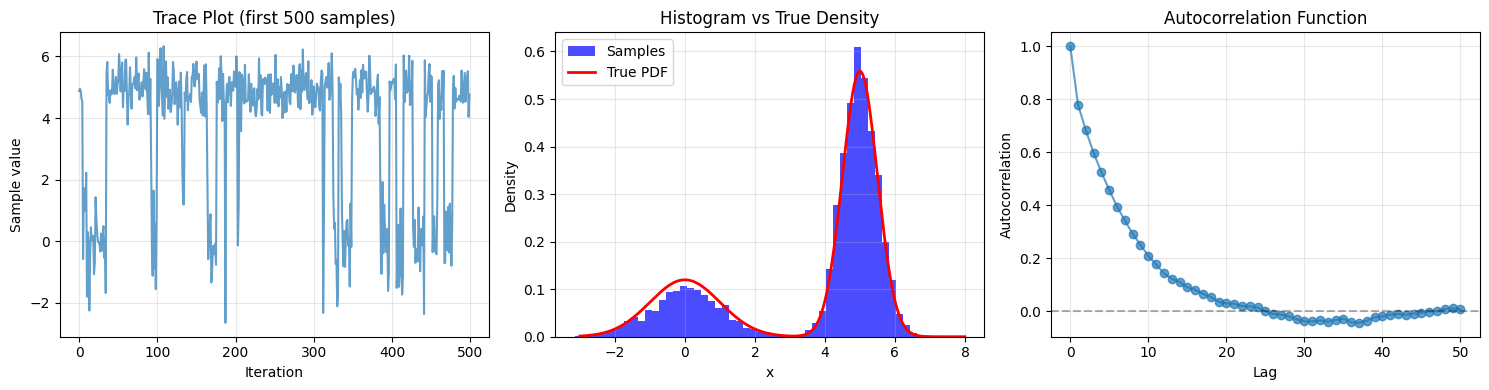

Sample mean: 3.720
Sample std: 2.290
True mean (approx): 3.500


In [4]:
example_gaussian_mixture()

In [5]:
def example_beta_distribution():
    """Example: Sampling from a Beta distribution."""
    print("\n" + "=" * 60)
    print("Example 2: Beta Distribution")
    print("=" * 60)

    # Define Beta(2, 5) distribution
    alpha, beta = 2, 5

    def log_pdf(x):
        if x <= 0 or x >= 1:
            return -np.inf
        return (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    # Initialize sampler
    sampler = SliceSampler(log_pdf, w=0.2, m=50)

    # Generate samples
    samples = sampler.sample(x0=0.5, n_samples=3000, burn_in=200, thin=1)

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram vs true density
    x_range = np.linspace(0.001, 0.999, 1000)
    true_pdf = stats.beta.pdf(x_range, alpha, beta)

    axes[0].hist(
        samples, bins=50, density=True, alpha=0.7, color="green", label="Samples"
    )
    axes[0].plot(
        x_range, true_pdf, "r-", linewidth=2, label=f"True Beta({alpha},{beta})"
    )
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("Density")
    axes[0].set_title("Histogram vs True Beta Distribution")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Q-Q plot
    theoretical_quantiles = stats.beta.ppf(
        np.linspace(0.01, 0.99, len(samples)), alpha, beta
    )
    sample_quantiles = np.sort(samples)

    axes[1].scatter(theoretical_quantiles, sample_quantiles, alpha=0.5, s=1)
    axes[1].plot([0, 1], [0, 1], "r--", linewidth=2)
    axes[1].set_xlabel("Theoretical Quantiles")
    axes[1].set_ylabel("Sample Quantiles")
    axes[1].set_title("Q-Q Plot")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Sample mean: {np.mean(samples):.4f}")
    print(f"True mean: {alpha / (alpha + beta):.4f}")
    print(f"Sample variance: {np.var(samples):.6f}")
    print(
        f"True variance: {alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1)):.6f}"
    )


Example 2: Beta Distribution
Generated 1000/3200 samples
Generated 2000/3200 samples
Generated 3000/3200 samples
Total log_pdf evaluations: 21485
Evaluations per sample: 6.71


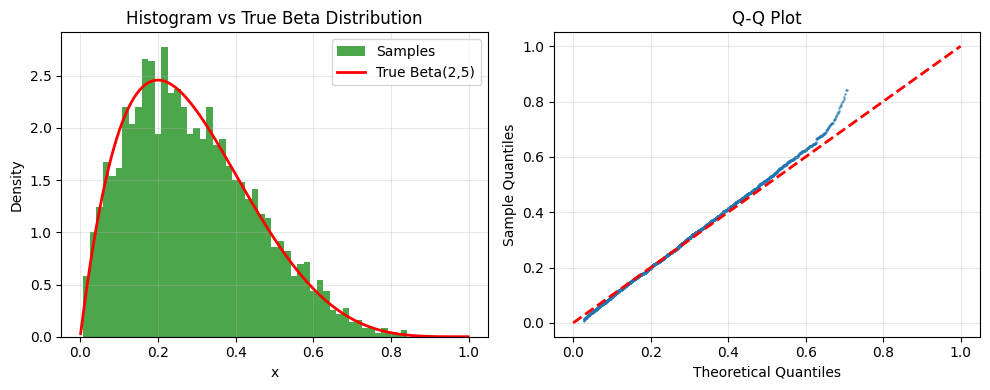

Sample mean: 0.2898
True mean: 0.2857
Sample variance: 0.026516
True variance: 0.025510


In [6]:
example_beta_distribution()

In [ ]:
def example_custom_distribution():
    """Example: Sampling from a custom multi-modal distribution."""
    print("\n" + "=" * 60)
    print("Example 3: Custom Multi-modal Distribution")
    print("=" * 60)

    # Define a complex multi-modal distribution
    def log_pdf(x):
        # Sum of Gaussian and truncated exponential distributions
        if x < -5 or x > 10:
            return -np.inf

        # Three modes
        mode1 = np.exp(-0.5 * ((x + 2) / 0.5) ** 2)
        mode2 = np.exp(-0.5 * ((x - 3) / 0.8) ** 2)
        mode3 = 0.5 * np.exp(-0.5 * ((x - 7) / 0.3) ** 2)

        # Add exponential decay
        exp_component = 0.3 * np.exp(-0.5 * max(0, x))

        return np.log(mode1 + mode2 + mode3 + exp_component + 1e-10)

    # Initialize sampler with adaptive parameters
    sampler = SliceSampler(log_pdf, w=3.0, m=100, verbose=False)

    # Generate samples
    samples = sampler.sample(x0=0.0, n_samples=10000, burn_in=1000, thin=2)

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples[:1000], alpha=0.7)
    plt.xlabel("Iteration")
    plt.ylabel("Sample value")
    plt.title("Trace Plot - Mode Jumping Behavior")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=100, density=True, alpha=0.7, color="purple")

    # Overlay approximate true density
    x_range = np.linspace(-5, 10, 1000)
    log_pdf_vec = np.array([log_pdf(x) for x in x_range])
    pdf_vec = np.exp(log_pdf_vec - np.max(log_pdf_vec))
    pdf_vec = pdf_vec / np.trapz(pdf_vec, x_range)  # Normalize

    plt.plot(x_range, pdf_vec, "r-", linewidth=2, label="True PDF (normalized)")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.title("Custom Multi-modal Distribution")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Sample statistics:")
    print(f"  Mean: {np.mean(samples):.3f}")
    print(f"  Std: {np.std(samples):.3f}")
    print(f"  Min: {np.min(samples):.3f}")
    print(f"  Max: {np.max(samples):.3f}")
    print(f"  Median: {np.median(samples):.3f}")


Example 3: Custom Multi-modal Distribution
Generated 1000/21000 samples
Generated 2000/21000 samples
Generated 3000/21000 samples
Generated 4000/21000 samples
Generated 5000/21000 samples
Generated 6000/21000 samples
Generated 7000/21000 samples
Generated 8000/21000 samples
Generated 9000/21000 samples
Generated 10000/21000 samples
Generated 11000/21000 samples
Generated 12000/21000 samples
Generated 13000/21000 samples
Generated 14000/21000 samples
Generated 15000/21000 samples
Generated 16000/21000 samples
Generated 17000/21000 samples
Generated 18000/21000 samples
Generated 19000/21000 samples
Generated 20000/21000 samples
Generated 21000/21000 samples
Total log_pdf evaluations: 144362
Evaluations per sample: 6.87


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15967/157441634.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_vec = pdf_vec / np.trapz(pdf_vec, x_range)  # Normalize


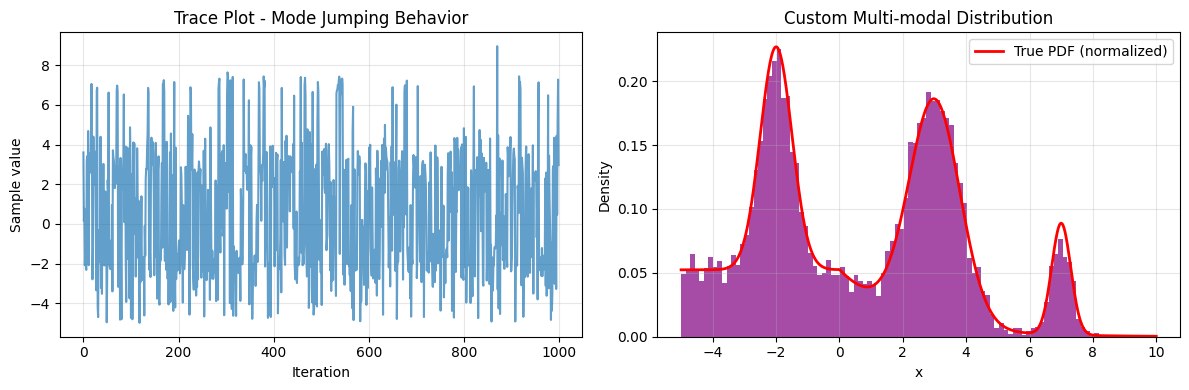

Sample statistics:
  Mean: 0.632
  Std: 3.142
  Min: -4.999
  Max: 9.338
  Median: 0.626


In [8]:
example_custom_distribution()